In [ ]:
!pip install tensorflow numpy pandas tqdm scikit-learn segmentation-models tensorflow-addons flammkuchen opencv-python-headless imageio

In [ ]:
import os
import tensorflow as tf
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

#from drive.MyDrive.Glottis.colab_glottis.GlottisNetV2.Utils.data import load_data, MAPE_V1, mape_apV1, mape_ppV1
from GlottisNetV2.Utils.data import load_data
from GlottisNetV2.Utils.Callbacks import get_callbacks
from GlottisNetV2.Models.GlottisNetV2_e import glottisnetV2_e


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import flammkuchen as fl
import cv2
import os
from tqdm.notebook import tqdm
import imageio as io
from tensorflow.keras.models import load_model
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import tensorflow_addons as tfa
from GlottisNetV2.Utils.data import load_data

# Iterate through videos
for vi in range(0, 1):

    # Set path of current video
    #vpath = r"drive/MyDrive/Glottis/videos/videos/" + str(vi) + ".mp4" # TODO: Set path
    vpath = r"drive/MyDrive/Glottis/videos_BAGLS/40.mp4" # TODO: Set path
    if os.path.exists(vpath):
        # Set model path
        path_model = r"drive/MyDrive/Glottis/GlottisNetV2e/models/steps/epoch025.h5" # TODO: Set path

        # Load frames fo video
        ims = io.mimread(vpath, memtest=False)

        # Load model
        Unet = load_model(path_model, compile=False,
                          custom_objects={'InstanceNormalization': tfa.layers.InstanceNormalization})

        # Initialize lists to hold data
        masks = []
        ims_orig = []

        # Iterate through frames
        for i in range(len(ims)):

            # Preprocess image for prediction
            img_orig = ims[i].astype(np.float32)

            # Color --> gray and normalize image
            img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img_orig, (256, 512))

            # Normalize and preprocess image
            normalizedImg = np.zeros(img.shape)
            img = cv2.normalize(img, normalizedImg, -1, 1, cv2.NORM_MINMAX)
            img = img[None, ..., None]

            # Prediction
            pred_maps, seg_pred = Unet.predict(img)
            mask = np.asarray(np.squeeze(seg_pred))

            # Convert probabilities to boolean
            mask = np.round(mask)

            # Resize, convert and transpose mask to get the right shape [frames, x, y] (type: boolean)
            mask = cv2.resize(mask, (img_orig.shape[1], img_orig.shape[0]))
            mask = mask.astype(bool)
            mask = np.transpose(mask, (1, 0))
            img_orig = np.transpose(img_orig, (1, 0))

            # Append images to lists
            masks.append(mask)
            ims_orig.append(img_orig)

        # Convert list to numpy array
        masks = np.asarray(masks)

        # Save sequence of masks as .mask file
        #path1 = r"drive/MyDrive/Glottis/masks/" + str(vi) + ".mask" # TODO: Set path
        path1 = r"drive/MyDrive/Glottis/GlottisNetV2e/Masks/40.mask" # TODO: Set path

        fl.save(path1, {"mask": masks, 'files': ims_orig}, compression='blosc')


In [ ]:
from google.colab.patches import cv2_imshow

# Ruta al archivo .mask que deseas visualizar
mask_file_path = "drive/MyDrive/Glottis/GlottisNetV2e/Masks/40.mask"  # Asegúrate de ajustar la ruta según tu ubicación

# Cargar el archivo .mask
data = fl.load(mask_file_path)

# Obtener las máscaras y las imágenes originales
masks = data["mask"]
images = data["files"]

# Iterar a través de las máscaras y mostrarlas junto con las imágenes originales
for i in range(len(masks)):
    # Escala la máscara para que sea más visible (puedes ajustar la escala según tus necesidades)
    scaled_mask = (masks[i] * 255).astype(np.uint8)

    # Muestra la imagen original y la máscara utilizando cv2_imshow
    cv2_imshow(images[i])
    cv2_imshow(scaled_mask)

In [ ]:
from google.colab.patches import cv2_imshow
import flammkuchen as fl
import cv2
import numpy as np

# Esta función encuentra contornos en la máscara y dibuja los contornos en la imagen original
def draw_contours_on_image(mask, img_orig, contour_color=(255, 255, 255)):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image
    img_with_contours = img_orig.copy()

    # Draw the contours on the original image using the specified contour_color
    cv2.drawContours(img_with_contours, contours, -1, contour_color, 2)

    return img_with_contours


# Configurar los parámetros del video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Puedes ajustar el códec según tus preferencias
# Inicializar las dimensiones de ancho y alto
ancho, alto = None, None

# Crear el objeto de video sin dimensiones (se configurarán más tarde)
output_video = None

for i in range(len(masks)):
    # Llama a la función para dibujar contornos
    img_with_contours = draw_contours_on_image(masks[i], images[i])

    # Convertir la imagen a 8 bits sin signo si no lo está ya
    if img_with_contours.dtype != np.uint8:
        img_with_contours = img_with_contours.astype(np.uint8)

    # Verificar si las dimensiones del video se han configurado
    if ancho is None or alto is None:
        alto, ancho = img_with_contours.shape[:2]
        # Crear el objeto de video con las dimensiones de la imagen
        output_video = cv2.VideoWriter('output_video.mp4', fourcc, 30, (ancho, alto))

    # Agregar la imagen con contornos al video
    output_video.write(img_with_contours)

    # Mostrar la imagen con los contornos utilizando cv2_imshow
    cv2_imshow(img_with_contours)

output_video.release()



In [ ]:
!pip install tensorflow numpy pandas tqdm scikit-learn segmentation-models tensorflow-addons flammkuchen opencv-python-headless imageio

In [4]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
import os
import imageio as io

def draw_contours_on_image(mask, img_orig_bgr, contour_color=(0, 255, 0), contour_thickness=3):
    # Encontrar contornos en la máscara
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Crear una copia de la imagen original
    if len(img_orig_bgr.shape) == 2 or img_orig_bgr.shape[2] == 1:
        img_with_contours = cv2.cvtColor(img_orig_bgr, cv2.COLOR_GRAY2BGR)
    else:
        img_with_contours = img_orig_bgr.copy()

    # Dibujar los contornos en la imagen original utilizando el color y grosor especificado
    cv2.drawContours(img_with_contours, contours, -1, contour_color, contour_thickness)

    return img_with_contours
# Función principal para procesar el video
def process_video(input_video_path, model_path, output_video_path):
    # Cargar el modelo
    Unet = load_model(model_path, compile=False, custom_objects={'InstanceNormalization': tfa.layers.InstanceNormalization})

    # Leer el video de entrada
    ims = io.mimread(input_video_path, memtest=False)

    # Configurar los parámetros del video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Puedes ajustar el códec según tus preferencias

    # Inicializar las dimensiones de ancho y alto
    ancho, alto = None, None

    # Crear el objeto de video sin dimensiones (se configurarán más tarde)
    output_video = None

    for img_orig in ims:
        # Preprocesar la imagen para la predicción
        img_bgr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2BGR)
        img_bgr = img_bgr.astype(np.float32)
        
        img_orig = img_orig.astype(np.float32)
    
        # Convertir a gris y normalizar la imagen
        img_orig_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img_orig_gray, (256, 512))

        # Normalizar y preprocesar la imagen
        normalizedImg = np.zeros(img.shape)
        img = cv2.normalize(img, normalizedImg, -1, 1, cv2.NORM_MINMAX)
        img = img[None, ..., None]

        # Predicción
        pred_maps, seg_pred = Unet.predict(img)
        mask = np.asarray(np.squeeze(seg_pred))

        # Convertir las probabilidades a booleanas
        mask = np.round(mask)

        # Redimensionar la máscara al tamaño original del frame
        mask = cv2.resize(mask, (img_orig_gray.shape[1], img_orig_gray.shape[0]))
        mask = mask.astype(bool)

        # Llama a la función para dibujar contornos
        img_with_contours = draw_contours_on_image(mask, img_bgr, contour_color=(0, 255, 0), contour_thickness=2)  # Contornos verdes

        # Convertir la imagen a 8 bits sin signo si no lo está ya
        if img_with_contours.dtype != np.uint8:
            img_with_contours = img_with_contours.astype(np.uint8)

        # Verificar si las dimensiones del video se han configurado
        if ancho is None or alto is None:
            alto, ancho = img_with_contours.shape[:2]
            # Crear el objeto de video con las dimensiones de la imagen
            output_video = cv2.VideoWriter(output_video_path, fourcc, 30, (ancho, alto))

        # Agregar la imagen con contornos al video
        output_video.write(img_with_contours)

    if output_video is not None:
        output_video.release()




In [ ]:
input_video_path = '/home/voicelab/Desktop/segmentation_glottis/datasets/BAGLS/raw/raw/155.mp4'
model_path = '/home/voicelab/Desktop/segmentation_glottis/models/UNets/S3AR-UNet/s3ar_unet/model/SeARUNet-1/SeARUNet-1.h5'
output_video_path = '/home/voicelab/Desktop/segmentation_glottis/UNet/videos/155_s3ar-unet.mp4'

process_video(input_video_path, model_path, output_video_path)

In [6]:
input_video_path ='/home/voicelab/Desktop/segmentation_glottis/datasets/videos_VPLab/FN001.avi'
model_path = "/home/voicelab/Downloads/epoch025.h5"
output_video_path = '/home/voicelab/Desktop/segmentation_glottis/models/UNets/UNet/videos/FN001_UNet_bgr.mp4'

process_video(input_video_path, model_path, output_video_path)


1/1 [==============================] - 0s 14ms/step


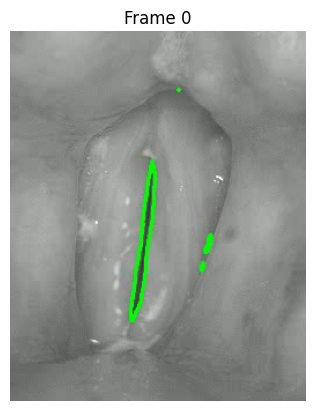

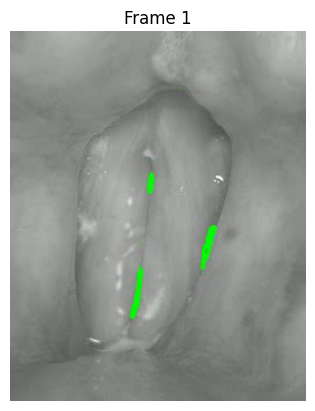

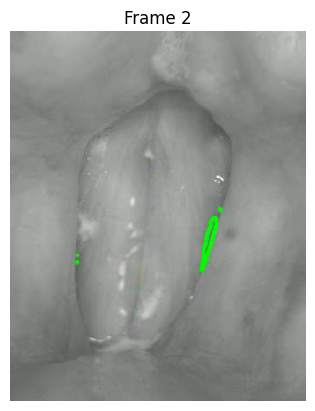

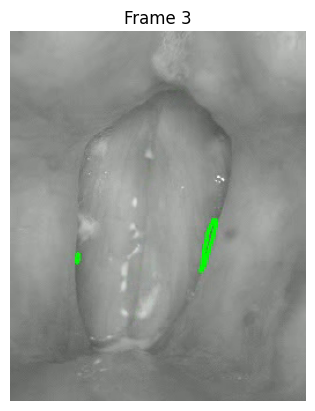

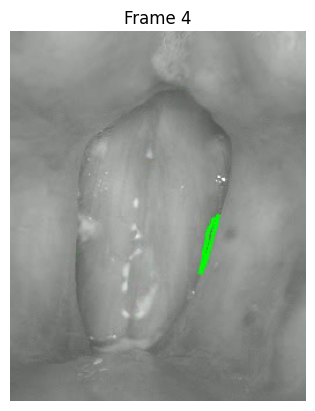

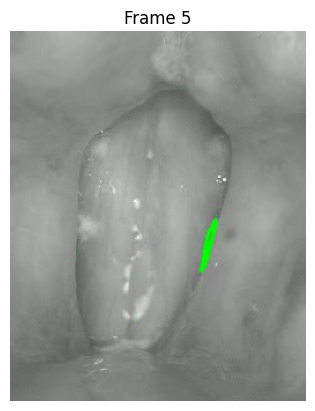

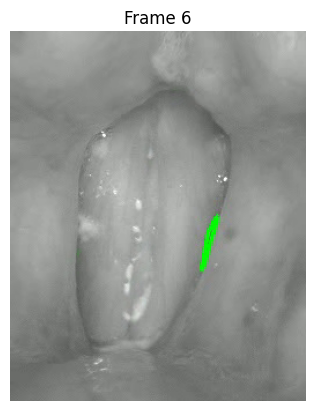

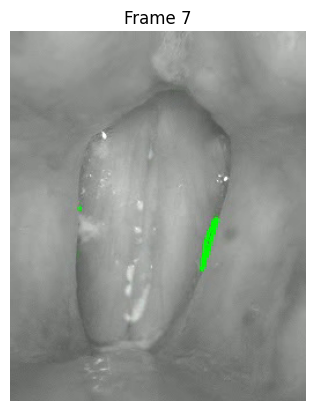

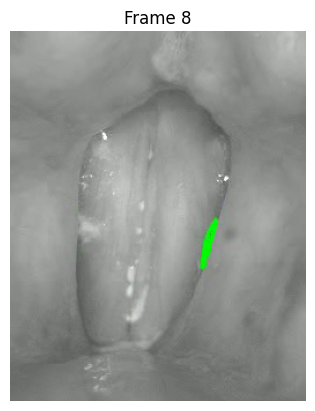

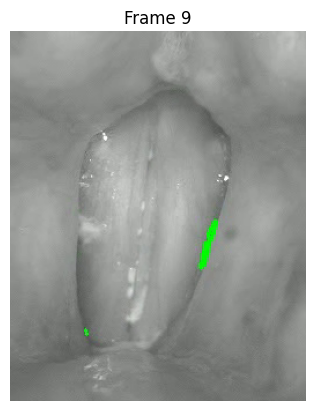

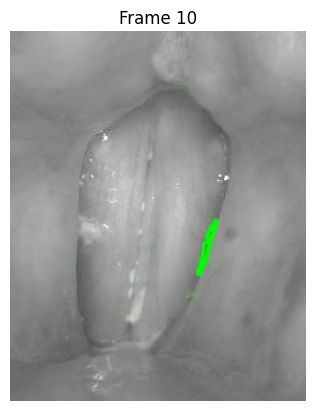

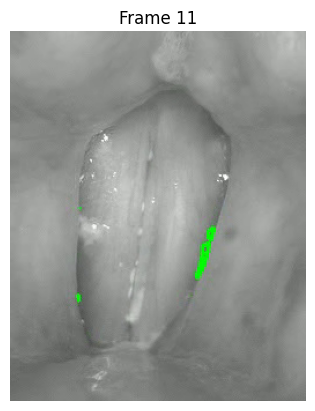

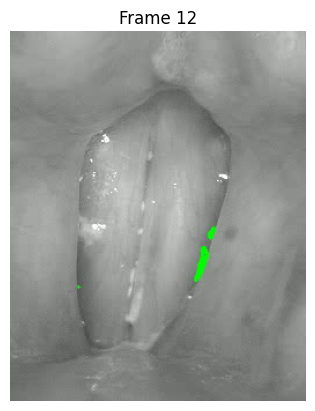

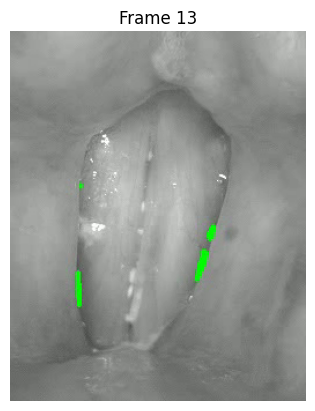

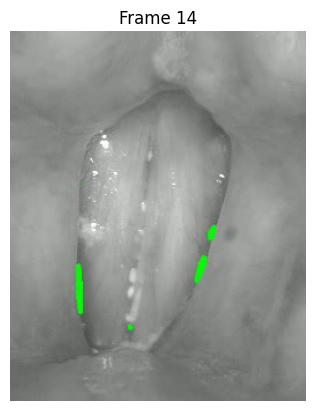

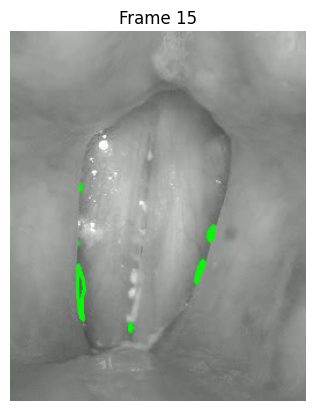

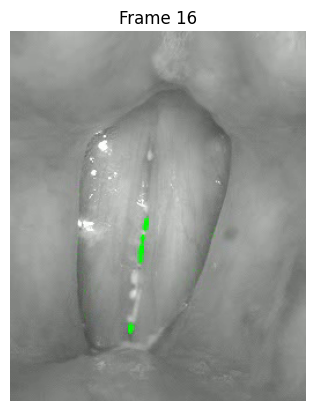

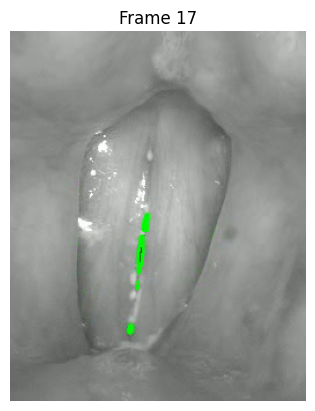

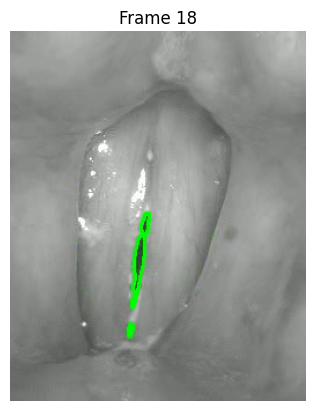

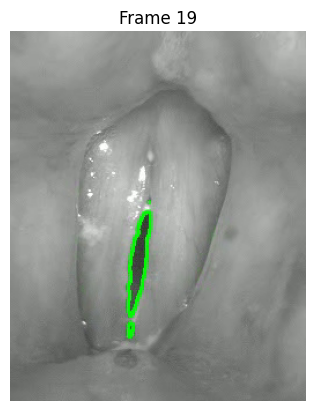

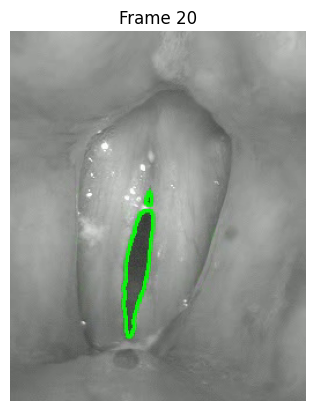

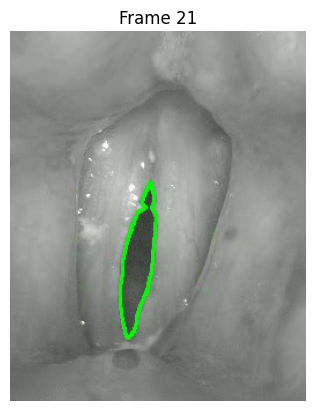

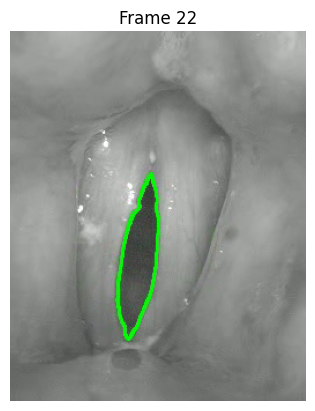

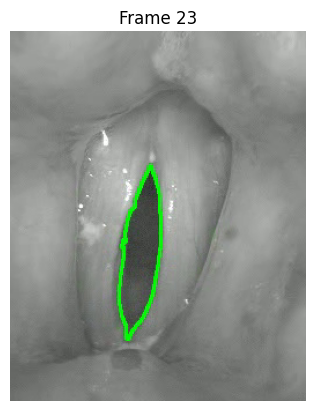

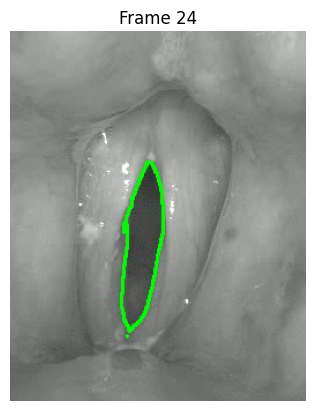

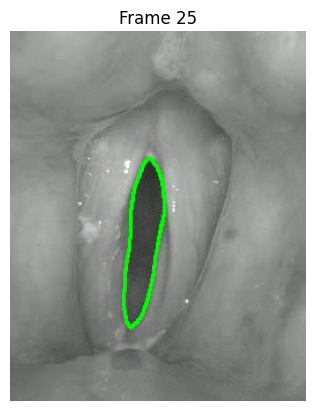

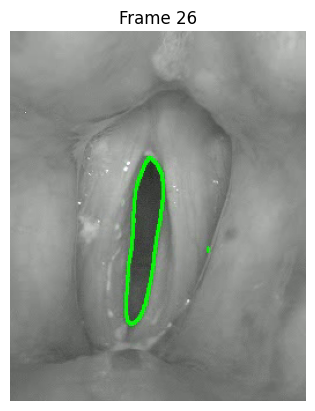

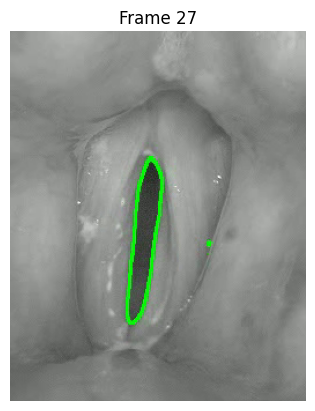

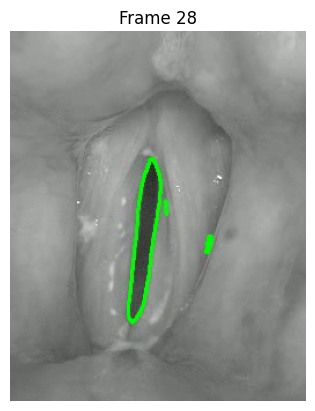

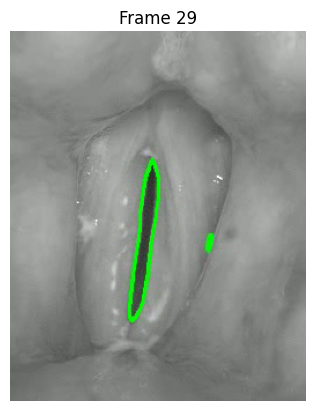

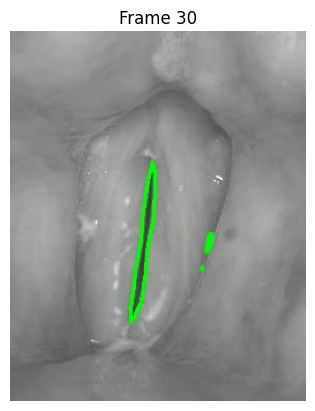

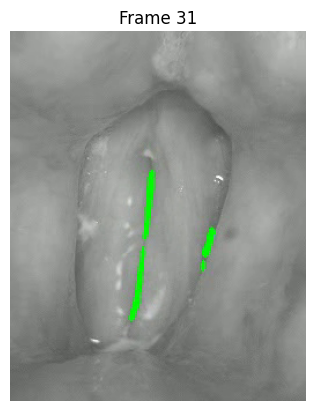

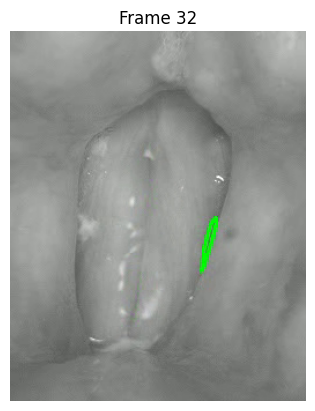

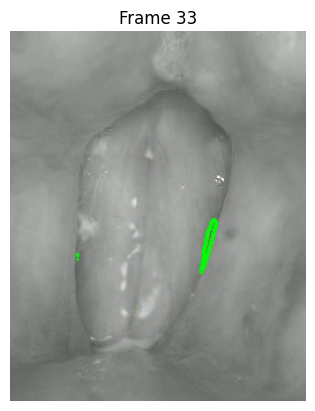

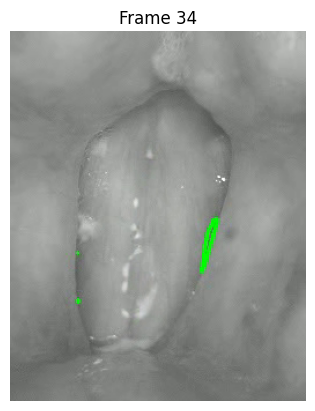

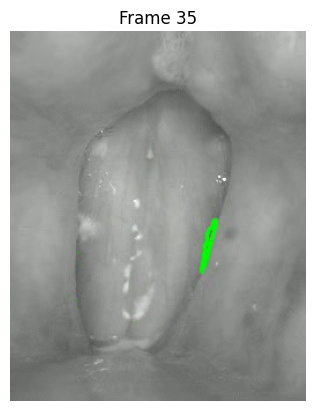

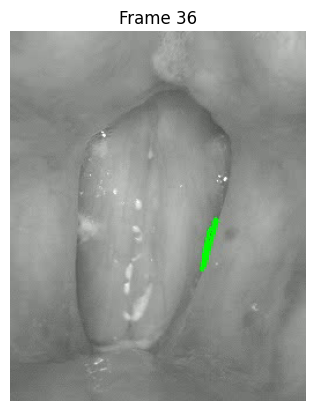

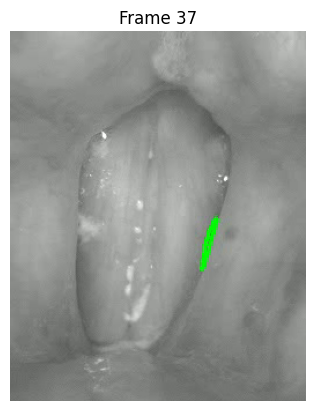

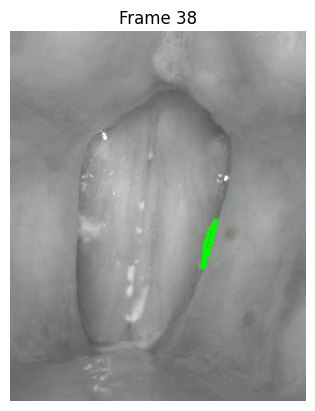

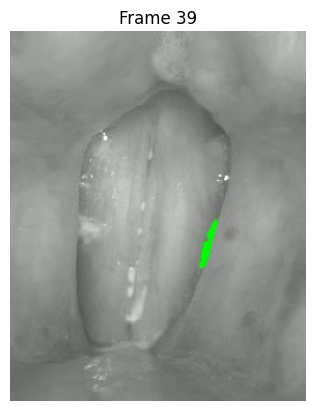

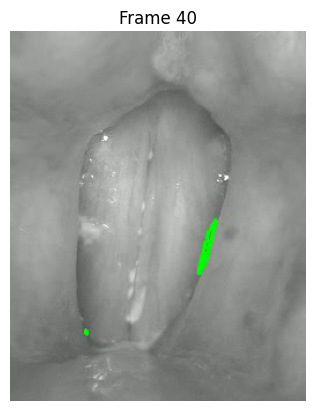

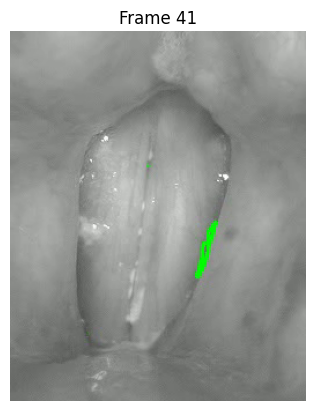

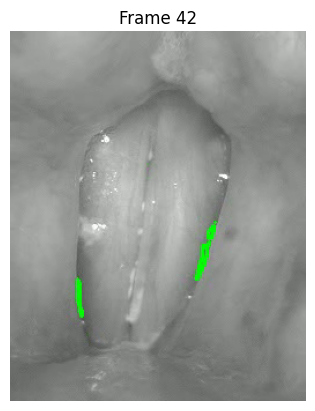

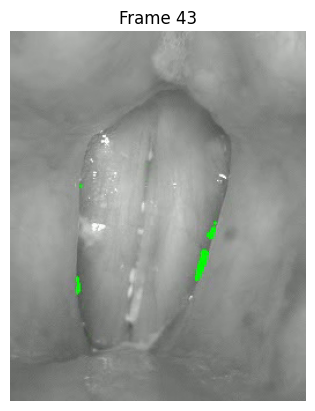

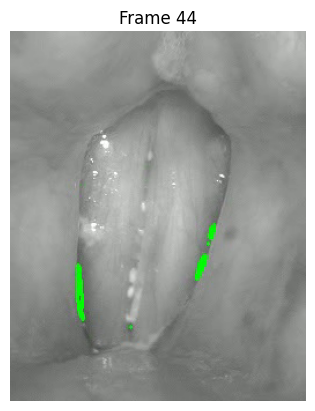

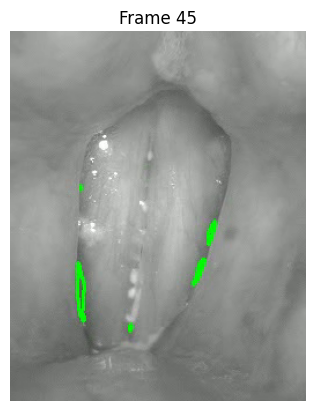

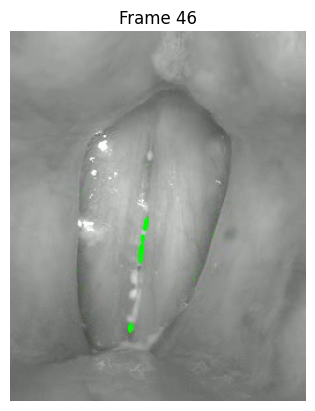

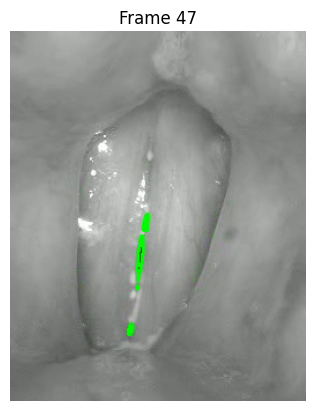

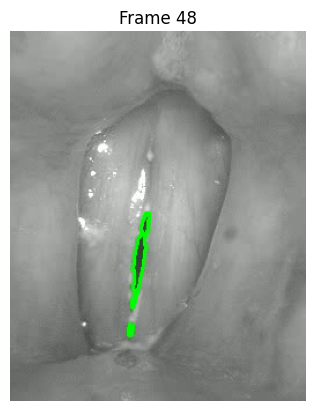

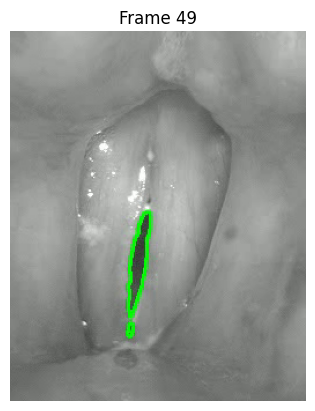

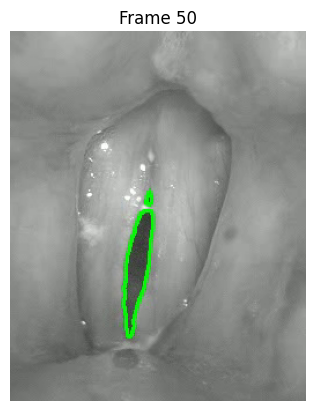

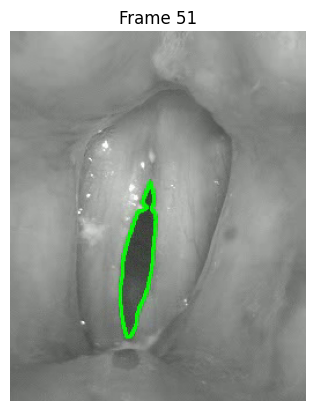

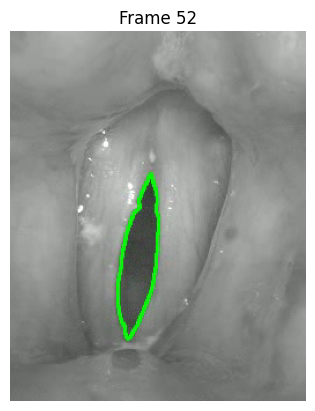

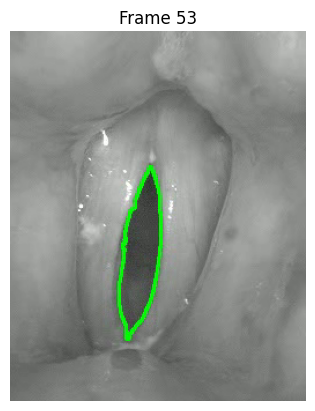

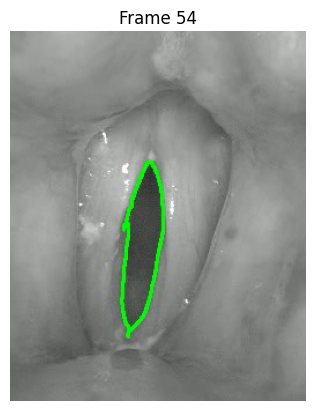

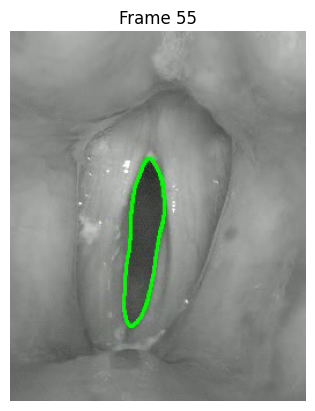

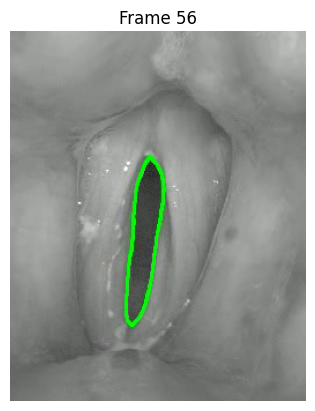

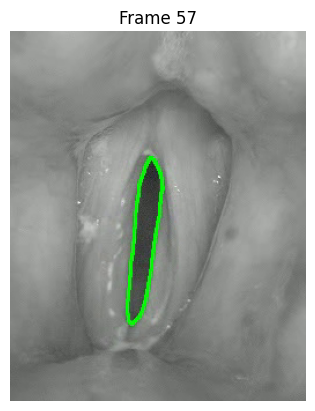

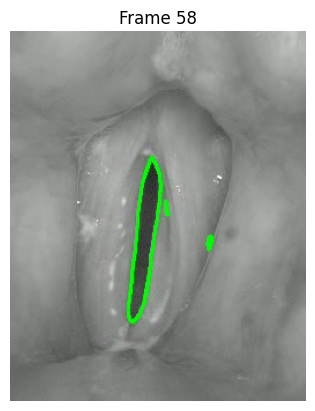

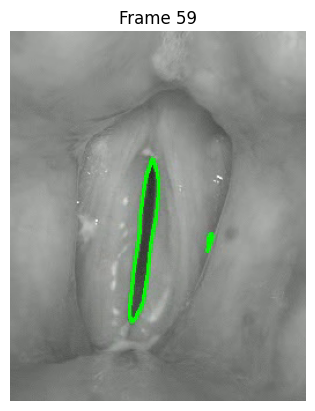

In [1]:
import cv2
import matplotlib.pyplot as plt

def show_frame(frame, frame_number):
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {frame_number}")
    plt.axis('off')
    plt.show()

# Cargar el video
video_path = "/home/voicelab/Desktop/segmentation_glottis/UNet/videos/155_Unet.mp4"
cap = cv2.VideoCapture(video_path)

# Leer y mostrar los primeros 60 frames
frame_count = 0
while frame_count < 60:
    ret, frame = cap.read()
    if not ret:
        print("Fin del video o error al cargar el video.")
        break
    
    # Mostrar el frame
    show_frame(frame, frame_count)
    
    frame_count += 1

# Liberar el video
cap.release()
